In [2]:
!pip install rdkit-pypi

In [3]:
!pip install rdkit networkx matplotlib


In [16]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx

# Dataset definition
class ZINCDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).sample(10000)
        self.smiles = self.data["smiles"].values

        # Optionally, precompute properties
        self.properties = []
        for smile in self.smiles:
            mol = Chem.MolFromSmiles(smile)
            if mol:
                logP = Descriptors.MolLogP(mol)

                qed = Chem.QED.qed(mol)

                sas = Descriptors.TPSA(mol)  # Approximate synthetic accessibility

                self.properties.append([logP, qed, sas])
            else:
                self.properties.append([0, 0, 10])  # Default invalid molecule values

        self.properties = np.array(self.properties, dtype=np.float32)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        features = np.zeros((2048,), dtype=np.float32)
        Chem.DataStructs.ConvertToNumpyArray(fingerprint, features)

        properties = self.properties[idx]

        return torch.tensor(features, dtype=torch.float32), torch.tensor(properties, dtype=torch.float32), smiles


# Noise schedule
def get_noise_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)


# Add noise to molecular features
def add_noise(features, noise_schedule, t):
    beta_t = noise_schedule[t].to(features.device)
    beta_t = beta_t.unsqueeze(1)
    noise = torch.randn_like(features)
    noisy_features = (1 - beta_t).sqrt() * features + beta_t.sqrt() * noise
    return noisy_features, noise


# Denoising model
class DenoisingModel(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingModel, self).__init__()
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.denoising_head = nn.Linear(512, input_dim)
        self.property_head = nn.Linear(512, 3)  # Predict logP, qed, SAS

    def forward(self, x, t_emb):
        x = self.shared_net(x)
        denoised_output = self.denoising_head(x)
        predicted_properties = self.property_head(x)
        return denoised_output, predicted_properties


# Training function
def train_ddpm(model, dataset, timesteps=300, epochs=3, batch_size=32, lr=1e-4):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    noise_schedule = get_noise_schedule(timesteps)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for features, properties, smiles in dataloader:
            features = features.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            properties = properties.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            t = torch.randint(0, timesteps, (features.size(0),), device=features.device)
            noisy_features, noise = add_noise(features, noise_schedule, t)

            denoised_output, predicted_properties = model(noisy_features, t)
            loss = nn.MSELoss()(denoised_output, noise) + 0.5 * nn.MSELoss()(predicted_properties, properties)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader)}")

    # Save the model after training
    torch.save(model.state_dict(), "ddpm_model.pth")
    print("Model saved.")





Streaming output truncated to the last 5000 lines.
q 0.888983906191477
s 65.97
lop 2.6598000000000006
q 0.8492964735186739
s 72.7
lop 2.5501000000000005
q 0.6080025173245595
s 20.23
lop 2.6072200000000008
q 0.8871594949450089
s 62.71
lop 0.24710000000000198
q 0.44400756310358325
s 84.36000000000001
lop 0.7078000000000013
q 0.7956340449750232
s 46.370000000000005
lop 0.4122000000000008
q 0.8851245224762629
s 57.709999999999994
lop 2.407819999999999
q 0.890609177342942
s 65.97
lop 0.7487999999999999
q 0.7204723998435064
s 78.9
lop 3.0965000000000007
q 0.8789432649184042
s 37.91
lop 4.716320000000004
q 0.45231832780324
s 67.23
lop 2.842600000000001
q 0.8484618334410654
s 61.440000000000005
lop 4.418400000000004
q 0.8129795697808477
s 29.540000000000003
lop 3.397000000000001
q 0.8757044152692397
s 29.1
lop 2.0848999999999998
q 0.7431117556953674
s 67.83
lop 2.8391
q 0.8942812609159275
s 42.22
lop 0.3871999999999997
q 0.6555672517231267
s 88.02000000000001
lop 1.6358999999999997
q 0.8027616

Streaming output truncated to the last 5000 lines.
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:24:57] DEPRECATION WARNING: please use MorganGenerator
[20:2

Epoch 1, Loss: 230.27969078819592


Streaming output truncated to the last 5000 lines.
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:25:15] DEPRECATION WARNING: please use MorganGenerator
[20:2

Epoch 2, Loss: 35.85447888785658


Streaming output truncated to the last 5000 lines.
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:25:32] DEPRECATION WARNING: please use MorganGenerator
[20:2

Epoch 3, Loss: 26.544964525265435
Model saved.
Enter maximum logP (e.g., -0.5): 2.5
Enter minimum QED (e.g., 0.5): 0.85
Enter maximum SAS (e.g., 6): 61.44
No valid molecules found for the given constraints.


Streaming output truncated to the last 5000 lines.
q 0.8290553693000193
s 92.15
lop 2.0029200000000005
q 0.5844200423948215
s 76.67999999999999
lop 3.820000000000003
q 0.7729410341767546
s 58.64
lop 3.805200000000001
q 0.7176715798571929
s 87.05000000000001
lop 2.1595999999999993
q 0.672695554497765
s 68.31
lop 1.7671000000000001
q 0.8331396883489902
s 72.47
lop 2.2334000000000005
q 0.828152252572254
s 99.24000000000001
lop 1.3720999999999997
q 0.887512819070284
s 78.84
lop 3.0345000000000013
q 0.8858705946897315
s 30.220000000000002
lop 3.9041400000000026
q 0.5847473415790746
s 64.22
lop 3.2059200000000017
q 0.906657669494297
s 50.95
lop 1.17752
q 0.7472201698220425
s 54.78
lop 3.717800000000002
q 0.7334258111967159
s 3.24
lop 0.7231000000000003
q 0.8482264500256583
s 20.57
lop 1.9599999999999997
q 0.8661318481415632
s 30.880000000000003
lop 3.564140000000002
q 0.3400929479215981
s 118.12
lop 4.238520000000004
q 0.8530209774387212
s 61.77
lop 3.125320000000002
q 0.8657925530876593
s 5

Streaming output truncated to the last 5000 lines.
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:01:11] DEPRECATION WARNING: please use MorganGenerator
[21:0

Epoch 1, Loss: 213.9315798640632


Streaming output truncated to the last 5000 lines.
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:01:26] DEPRECATION WARNING: please use MorganGenerator
[21:0

Epoch 2, Loss: 34.09624742928404


Streaming output truncated to the last 5000 lines.
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:01:40] DEPRECATION WARNING: please use MorganGenerator
[21:0

Epoch 3, Loss: 25.06107026243362
Model saved.
Enter maximum logP (e.g., -0.5): 5
Enter minimum QED (e.g., 0.5): 0.2
Enter maximum SAS (e.g., 6): 30
[('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0), ('C', 0.6361, 0.3597849378839701, 0.0)]
Generated valid molecules:
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 0.36, SAS: 0.00
SMILES: C, logP: 0.64, QED: 

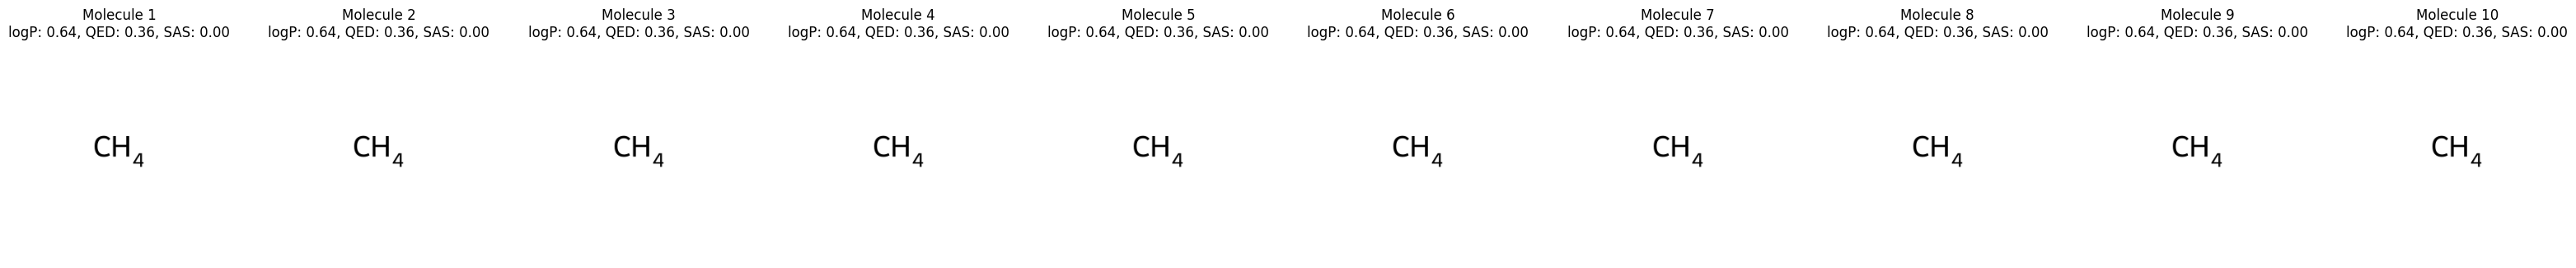

In [22]:

def sample_ddpm_with_filters_and_fallback(model, timesteps, num_samples, logP_max, qed_min, sas_max):
    model.eval()
    noise_schedule = get_noise_schedule(timesteps)
    samples = torch.randn((num_samples, 2048), device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    valid_molecules = []
    fallback_molecule = None
    fallback_distance = float('inf')

    for t in reversed(range(timesteps)):
        beta_t = noise_schedule[t].to(samples.device)
        denoised_features, _ = model(samples, t)
        samples = (1 / (1 - beta_t).sqrt()) * (samples - beta_t.sqrt() * denoised_features)


    # Generate SMILES and filter by properties
    for sample in samples.cpu().detach().numpy():
        fingerprint = np.round(sample).astype(int)
        fingerprint = np.clip(fingerprint, 0, 1)

        try:
            mol = AllChem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles("C")))  # Example placeholder
            if mol:
                logP = Descriptors.MolLogP(mol)
                qed = Chem.QED.qed(mol)
                sas = Descriptors.TPSA(mol)  # Use TPSA as a proxy for SAS

                # Check constraints
                if logP <= logP_max and qed >= qed_min and sas <= sas_max:
                    valid_molecules.append((Chem.MolToSmiles(mol), logP, qed, sas))

                # Track fallback molecule (closest match)
                distance = abs(logP - logP_max) + abs(qed - qed_min) + abs(sas - sas_max)
                if distance < fallback_distance:
                    fallback_distance = distance
                    fallback_molecule = (Chem.MolToSmiles(mol), logP, qed, sas)
        except Exception as e:
            continue

    # Use valid molecules or fallback
    if valid_molecules:
        return valid_molecules  # Return the first valid molecule
    else:
        return fallback_molecule  # Return the closest match if no valid molecule found


# Visualize multiple molecules side by side
def visualize_multiple_molecules(molecule_data, filename=None):
    if not molecule_data:
        print("No valid molecules found for the given constraints.")
        return

    num_molecules = len(molecule_data)
    fig, axes = plt.subplots(1, num_molecules, figsize=(4 * num_molecules, 4))

    if num_molecules == 1:
        axes = [axes]  # Wrap single axis in a list for consistency

    for i, (smiles, logP, qed, sas) in enumerate(molecule_data):
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(300, 300)) if mol else None
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Molecule {i + 1}\nlogP: {logP:.2f}, QED: {qed:.2f}, SAS: {sas:.2f}")

    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()




# Main workflow
if __name__ == "__main__":
    dataset = ZINCDataset("zink_database.csv")
    input_dim = 2048
    timesteps = 300
    model = DenoisingModel(input_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # Train the model
    train_ddpm(model, dataset, timesteps=timesteps, epochs=3)

    # Get user input for properties
logP_max = float(input("Enter maximum logP (e.g., -0.5): "))
qed_min = float(input("Enter minimum QED (e.g., 0.5): "))
sas_max = float(input("Enter maximum SAS (e.g., 6): "))

# Generate molecules with filters
generated_molecules = sample_ddpm_with_filters_and_fallback(model, timesteps=timesteps, num_samples=10,
                                               logP_max=logP_max, qed_min=qed_min, sas_max=sas_max)

# Visualize the generated molecules

if generated_molecules:
    print(generated_molecules)

    print("Generated valid molecules:")
    for smiles, logP, qed, sas in generated_molecules:
        print(f"SMILES: {smiles}, logP: {logP:.2f}, QED: {qed:.2f}, SAS: {sas:.2f}")
    visualize_multiple_molecules(generated_molecules)
else:
    print("No valid molecules found for the given constraints.")

